In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

%matplotlib inline

#### Image Feature Extraction Methods

In [305]:
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features_from_image(img, spatial_size=(32, 32),
                                hist_bins=32, orient=9, pix_per_cell=8, 
                                cell_per_block=2, hog_channel=0, spatial_feat=True, 
                                hist_feat=True, hog_feat=True, image_size=(64,64)):
    
    

    hog_features = []
    for channel in range(img.shape[2]):
        hog_features.append(get_hog_features(img[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
    #spatial_features = bin_spatial(img, size=spatial_size)
    #hist_features = color_hist(img, nbins=hist_bins)
    #features = np.concatenate((spatial_features, hist_features, hog_features))
    return hog_features

#### Model Training Extraction Methods

In [329]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        
        features.append(extract_features_from_image(feature_image))
    return features

#### Global Feature Extraction Parameters

In [330]:

f_color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
f_orient = 9  # HOG orientations
f_pix_per_cell = 8 # HOG pixels per cell
f_cell_per_block = 2 # HOG cells per block
f_hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
f_spatial_size = (32, 32) # Spatial binning dimensions
f_hist_bins = 32    # Number of histogram bins
f_spatial_feat = True # Spatial features on or off
f_hist_feat = True # Histogram features on or off
f_hog_feat = True # HOG features on or off
f_image_size = (64,64)



#### Prepare Training Data

In [340]:

notcars = glob.glob('non-vehicles/Extras/*.png')
notcarstoo = glob.glob('object-dataset-notcars/*.png')
cars = glob.glob('vehicles/KITTI_extracted/*.png')
carstoo = glob.glob('object-dataset-cars/*.png')

notcars = notcars + notcarstoo
cars = cars + carstoo

t=time.time()


colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


In [341]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(y.shape)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

174.99 Seconds to extract HOG features...
(27905, 5292)
(27905,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


#### Train Classifier

In [345]:

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

68.52 Seconds to train SVC...
Test Accuracy of SVC =  0.8975
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
0.00269 Seconds to predict 10 labels with SVC


In [346]:
d = []
for n in notcars[:100]:
    image = cv2.imread(n)
    cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    feat = extract_features_from_image(img, orient=f_orient, 
                        pix_per_cell=f_pix_per_cell, cell_per_block=f_cell_per_block, 
                        hog_channel=f_hog_channel,image_size=f_image_size,
                        spatial_feat=f_spatial_feat, hist_feat=f_hist_feat, hog_feat=f_hog_feat)
    
    feat = X_scaler.transform([feat])
    d.append(svc.predict(feat))

print(np.mean(d))

0.0


#### Window Functions

1. Define the window params
2. Build the windows
3. Search all windows
4. Hot windows

I'm a little bit lost now... it's always a balance of plug and play viz, + getting something that works as a pipeline. What you want is something that's flexible enough that you can still debug once it gets bigger.

In [398]:


def find_cars(img, ystart, ystop, scale=1.0, 
              model=None, scaler=None, orient=9, pix_per_cell=8, 
              cell_per_block=2, spatial_size=(32,32), hist_bins=32, 
              steps=2, xstart=0, xstop=1280):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = steps  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    #print("find",(xstart,xstop), (ystart,ystop), scale, nxsteps, nysteps, nblocks_per_window)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    search_boxes = []
    imgs = []
    cut_feat = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
        
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            
            #features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            features = hog_features.reshape(1, -1)
            #features = extract_features_from_image(subimg).reshape(1, -1)
            # Scale features and make a prediction
            test_features = scaler.transform(features)
            test_prediction = model.predict(test_features)
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box = [(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)]
            search_boxes.append(box)
            if test_prediction == 1:
                imgs.append(subimg)
                cut_feat.append(features)
                boxes.append(box)
    
    return boxes, search_boxes, imgs, cut_feat

In [750]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    car_boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        car_boxes.append(bbox)
        # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return car_boxes

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [762]:

def detect_in_frame(img, sizes):
    box_list = []
    search_list = []
    imgs = []
    cut_feat = []
    for xstartstop, ystartstop, scale, steps in sizes:
        #print("detect", xstartstop, ystartstop)
        boxes, search_boxes, imgs, cut_feat = find_cars(img, ystartstop[0], ystartstop[1],
                          scale=scale, model=svc, scaler=X_scaler, 
                          orient=f_orient, pix_per_cell=f_pix_per_cell, cell_per_block=f_cell_per_block, 
                          spatial_size=f_spatial_size, hist_bins=f_hist_bins, steps=steps, 
                          xstart=xstartstop[0], xstop=xstartstop[1])
        if len(boxes) > 0:
            box_list.append(boxes)
            search_list.append(search_boxes)
    if len(box_list) > 0:
        box_list = np.concatenate(box_list)
        search_list = np.concatenate(search_list)
    return box_list, search_list, imgs, cut_feat

def convert_box_to_window(boxes):
    buffer_ratio = 0.1
    new_windows = []
    for b in boxes:
        min_dim = np.amin(b, axis=0)
        max_dim = np.amax(b, axis=0)
        height = (max_dim[1] - min_dim[1])
        width = (max_dim[0] - min_dim[0])
        
        dimension = max(height, width)
        diff = np.absolute(height-width)
        
        buffer = dimension * buffer_ratio
        window_size = ((dimension + (2*buffer)), (dimension + (2*buffer)))
        xstartstop = np.clip(np.int32((min_dim[0]-buffer, max_dim[0]+buffer)), 0, 1280)
        ystartstop = np.clip(np.int32((min_dim[1]-buffer, max_dim[1]+buffer)), 380, 600)
        b128 = [np.clip((xstartstop[0]-16, xstartstop[1]+16), 0, 1280), np.clip((ystartstop[0]-16, ystartstop[1]+16), 380, 600), 2, 2]
        b96 = [np.clip((xstartstop[0]-12, xstartstop[1]+12), 0, 1280), np.clip((ystartstop[0]-12, ystartstop[1]+12), 380, 600), 1.5, 2]
        b64 = [np.clip((xstartstop[0]-8, xstartstop[1]+8), 0, 1280), np.clip((ystartstop[0]-8, ystartstop[1]+8), 380, 600), 1.0, 2]
        b48 = [np.clip((xstartstop[0]-6, xstartstop[1]+6), 0, 1280), np.clip((ystartstop[0]-6, ystartstop[1]+6), 380, 600), 0.75, 2]
        #print("new:", dimension, buffer, xstartstop, ystartstop, b128, b96, b64, b48)
        if window_size[0] > 128 and window_size[1] > 128:
            new_windows.append(b128)
            new_windows.append(b96)
            new_windows.append(b64)
        elif window_size[0] > 96 and window_size[1] > 96:
            new_windows.append(b96)
            new_windows.append(b64)
            new_windows.append(b48)
        elif window_size[0] > 64 and window_size[1] > 64:
            new_windows.append(b64)
            new_windows.append(b48)
        elif window_size[0] > 48 and window_size[1] > 48:
            new_windows.append(b48)
        else:
            #print("Window too small", window_size)
            pass
               
    return new_windows

class Detection:
    
    def __init__(self, boxes):
        self.age = 0
        self.boxes = boxes
    
    def increment_age(self, increment=1):
        self.age += increment
    
    def get_age(self):
        return self.age


class VehicleDetection:
    
    def __init__(self):
        self.box_set = []
        self.car_boxes = []
        self.detections = []
        self.last_detection = Detection([])
        self.box_set_size = 3
        self.full_search = 12
        self.full_search_limit = 13
        self.frame_threshold = 3
        self.base_sizes = [[(0, 1280), (380, 576), 2, 5], #128x128
                           [(0, 1280), (380, 576), 1.5, 3], #96x96
                           [(0, 1280), (380, 520), 1.0, 4],#, #64x64
                           [(0, 1280), (400, 520), 0.75, 4]]

    def annotate_frame(self, img):
        self.full_search += 1
        draw_img = np.copy(img)
        f_heat = np.zeros_like(img[:,:,:]).astype(np.float)
        heat = np.zeros_like(img[:,:,:]).astype(np.float)
        
        #search frame for existing windows
        search_boxes = []
        if len(self.car_boxes) > 0:
            search_boxes = self.car_boxes
        else:
            search_boxes = self.last_detection.boxes
        window_sizes = convert_box_to_window(search_boxes)
        box_list, search_list, imgs, cut_feat = detect_in_frame(img, window_sizes)
        thresh_scale = 2
        
        #search full frame every n interations
        if self.full_search % self.full_search_limit == 0:
            thresh_scale = 3
            full_box_list, full_search_list, imgs, cut_feat = detect_in_frame(img, self.base_sizes)
            #combine result set
            if len(search_list) > 0 and len(full_search_list) > 0:
                search_list = np.concatenate([search_list, full_search_list])
            else:
                search_list = full_search_list
            if len(box_list) > 0 and len(full_box_list) > 0:
                box_list = np.concatenate([box_list, full_box_list])
            else:
                box_list = full_box_list
        
        #positive detections
        #calculate bounding boxes
        self.last_detection = Detection([])
        if len(box_list) > 0:
            f_heat = add_heat(f_heat,box_list)
            f_heat = apply_threshold(f_heat,thresh_scale)
            f_heatmap = np.clip(f_heat, 0, 255)
            f_labels = label(f_heatmap)
            f_boxes = draw_labeled_bboxes(np.copy(img), f_labels)
            if len(f_boxes) > 0:
                #add detection to detections array
                detect = Detection(f_boxes)
                self.detections.append(detect)
                self.last_detection = detect
        
        #calculate car boxes from last detections
        if len(self.detections) > 0:
            car_list = np.concatenate([d.boxes for d in self.detections])
            heat = add_heat(heat,car_list)
            heat = apply_threshold(heat,max(3, len(self.detections) - 2))
            heatmap = np.clip(heat, 0, 255)
            labels = label(heatmap)
            car_boxes = draw_labeled_bboxes(np.copy(img), labels)
            self.car_boxes = car_boxes
        else:
            self.car_boxes = []
        
        #detection_boxes = np.concatenate([d.boxes for d in self.detections])
        
        #draw_img = draw_boxes(draw_img, search_boxes, (230, 230, 230), 9)
        #draw_img = draw_boxes(draw_img, search_list) #car_boxes)
        #draw_img = draw_boxes(draw_img, box_list, (0, 255, 0), 5)
        #draw_img = draw_boxes(draw_img, detection_boxes, (117,107,177), 3)
        draw_img = draw_boxes(draw_img, self.car_boxes, (255,0,0), 2)
        
        #font = cv2.FONT_HERSHEY_SIMPLEX
        #data = str(max(3, len(self.detections) - 1))+","+str(len(self.detections) - 1)
        #cv2.putText(draw_img, data, (40,100), font, 1.5,(37,37,37),3)
        
        for d in self.detections:
            d.increment_age()
        self.detections = [d for d in self.detections if d.get_age() < 5]
            
        return draw_img


In [764]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

detection_pipeline = VehicleDetection()

white_output = 'project_full_output_c.mp4'

# project_window_fix is good!

clip1 = VideoFileClip("project_video.mp4")#.subclip(39,41)
white_clip = clip1.fl_image(detection_pipeline.annotate_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_full_output_c.mp4
[MoviePy] Writing video project_full_output_c.mp4



 20%|██        | 257/1261 [00:53<05:00,  3.34it/s]


 32%|███▏      | 408/1261 [01:47<04:24,  3.22it/s]


 46%|████▌     | 576/1261 [02:41<03:54,  2.92it/s]


 58%|█████▊    | 727/1261 [03:39<02:44,  3.25it/s]


 70%|██████▉   | 878/1261 [04:51<03:25,  1.86it/s]


 82%|████████▏ | 1029/1261 [06:28<02:57,  1.31it/s]


 93%|█████████▎| 1177/1261 [07:46<00:32,  2.57it/s]


100%|█████████▉| 1260/1261 [08:18<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_full_output_c.mp4 

CPU times: user 7min 4s, sys: 53.1 s, total: 7min 57s
Wall time: 8min 20s


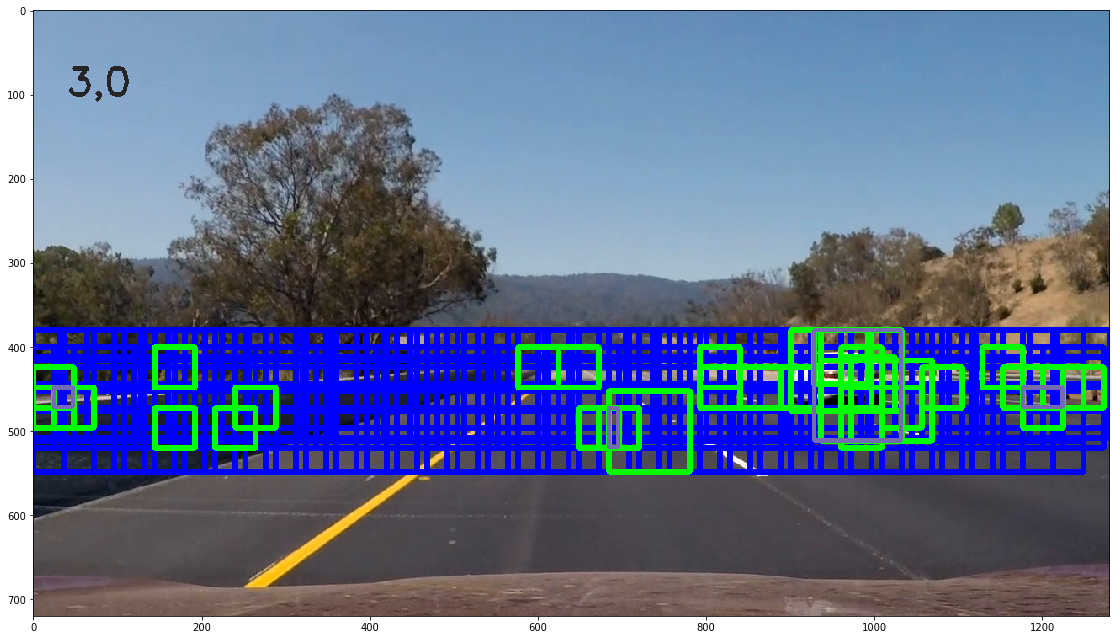

In [752]:
detection_pipeline = VehicleDetection()
clip1 = VideoFileClip("project_video.mp4").subclip(10,12)
first = clip1.get_frame(0)
img = detection_pipeline.annotate_frame(first)
f,(ax1) = plt.subplots(1, 1, figsize=(26, 9))
f.tight_layout()
ax1.imshow(img)

15 185


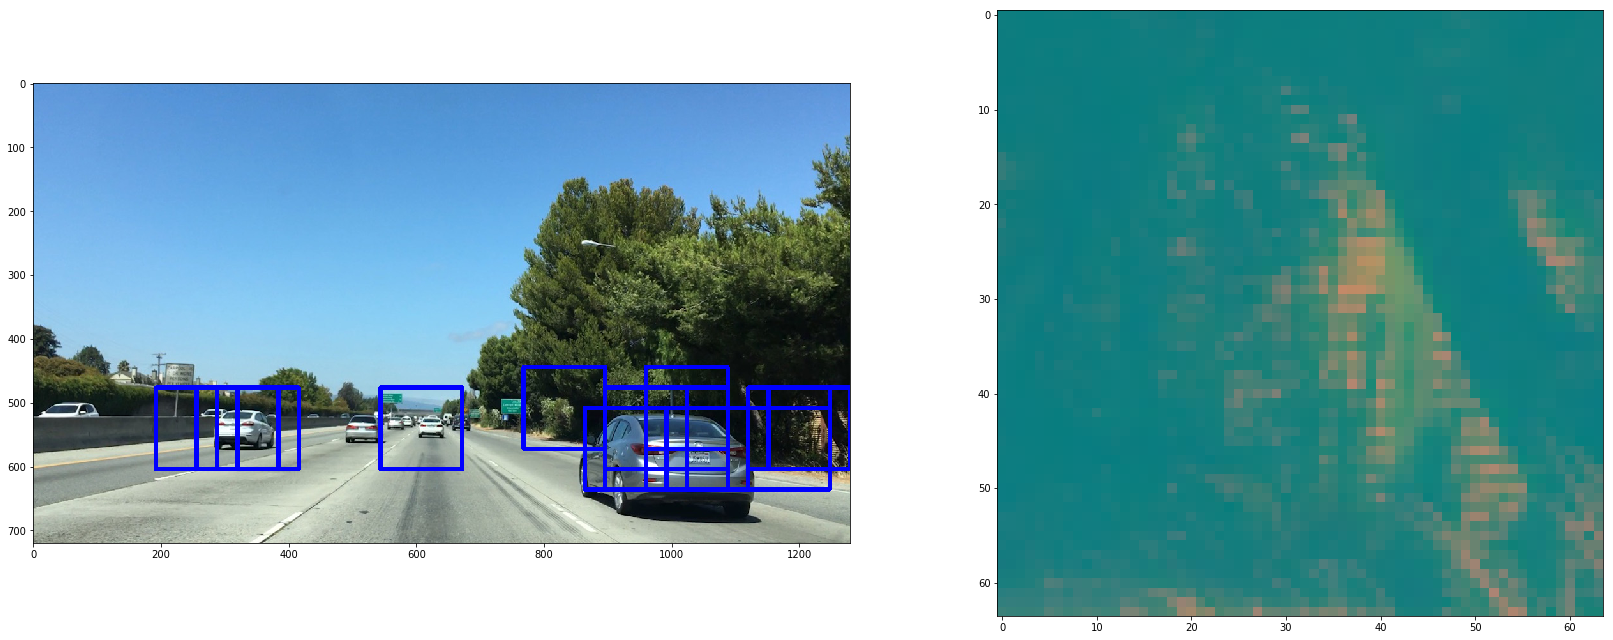

In [339]:
# base_sizes = [[(0, 1280), (380, 650), 2, 4], #128x128
#                   [(0, 1280), (380, 650), 1.5, 2], #96x96
#                   [(0, 1280), (380, 650), 1.0, 2]]#, #64x64

base_sizes = [[(0, 1280), (380, 650), 2, 2]]

image = cv2.imread('test_images/bbox-example-image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

boxes, search_list, imgs, cut_feat = detect_in_frame(image, base_sizes)

window_img = draw_boxes(draw_image, boxes, color=(0, 0, 255), thick=6)                    

f,(ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(window_img)

print(len(boxes), len(search_list))

d_boxes, search_boxes, imgs, cut_feat = find_cars(image, 380, 650,
                            scale=2, model=svc, scaler=X_scaler, 
                            orient=9, pix_per_cell=8, cell_per_block=2, 
                            spatial_size=(32,32), hist_bins=32, steps=2)
d_img = draw_boxes(draw_image, d_boxes, color=(0, 0, 255), thick=6) 

# window_img = draw_boxes(draw_image, boxes, color=(0, 0, 255), thick=6) 
# f,(ax1) = plt.subplots(1, 1, figsize=(24, 9))
# f.tight_layout()
ax2.imshow(imgs[-1])



In [363]:
for img in imgs:
    
    feat = extract_features_from_image(img)
    feat = X_scaler.transform(features)
    #print(svc.predict(feat))


In [259]:
d = []
for n in notcars:
    image = cv2.imread(n)
    cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    feat = extract_features_from_image(img)
    feat = X_scaler.transform(features)
    d.append(svc.predict(feat))

print(np.mean(d))

1.0


161
[ 1.]


(64, 64, 3)

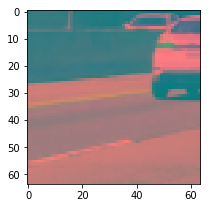

In [246]:
d_boxes, imgs, cut_feat = find_cars(image, 380, 650,
                            scale=2, model=svc, scaler=X_scaler, 
                            orient=9, pix_per_cell=8, cell_per_block=2, 
                            spatial_size=(32,32), hist_bins=32, steps=2)

subimg= cut_feat[33]
f,(ax1) = plt.subplots(1, 1, figsize=(8, 3))
f.tight_layout()
ax1.imshow(subimg)
print(len(cut_feat))

features = extract_features_from_image(subimg).reshape(1, -1)
            # Scale features and make a prediction
test_features = X_scaler.transform(features)
test_prediction = svc.predict(test_features)
print(test_prediction)
cut_feat[30].shape


In [ ]:
for i in range(0, len(imgs)):
    features = extract_features_from_image(imgs[i]).reshape(1, -1)
    test_features = X_scaler.transform(features)
    test_prediction = svc.predict(test_features)
    cache_prediction = svc.predict(cut_feat[i])
    if cache_prediction != test_prediction:
        f,(ax1) = plt.subplots(1, 1, figsize=(8, 3))
        f.tight_layout()
        ax1.imshow(np.clip(imgs[i],0,1))
        ax1.set_title("Now: {0}, Cache: {3}, Box: {1}, IMG: {2}".format(int(test_prediction), d_boxes[i], i, int(cache_prediction)), fontsize=11)

In [ ]:
features = extract_features_from_image(imgs[0]).reshape(1, -1)
test_features = X_scaler.transform(features)
comp = cut_feat[0]
for i in range(1, len(comp[0])):
    if comp[0][i] != features[0][i]:
        print(i)
        break
print(features)
print(comp)

In [ ]:
c = ((912, 428), (927, 475))
print(np.amin(c, axis=0))
print(np.amax(c, axis=1))
np.uint8([1.222])

